# simSPI Tutorial

In this tutorial, we will use the simSPI package to simulate a cryo-em experiement of the structure of the human 80S ribosome, protein with PDB code 4V6X [1]. In order to run the tests, it is also necessary to have installed the TEM-simulator [2].


<p align="center">
    <img src="4v6x_atomic_model.png" width=350 height=350 />
    <p style="text-align: center">
        Figure 1: Atomic model of the human 80S ribosome
    </p>
</p>

[1] https://www.rcsb.org/structure/4v6x

[2] http://tem-simulator.sourceforge.net/

In [1]:
from matplotlib import pyplot as plt, axes as ax
import torch
import numpy as np
import raster_geometry
import os
import warnings

from ioSPI import cryoemio, fourier
from simSPI import tem, transfer, multislice
from simSPI.linear_simulator import noise_utils, shift_utils


#Helper functions
def plot_image(img, scale, cmap='gray'):
    if img.shape[0] == 1:
         height, width = img.shape[1:]
    else:
        height, width = img.shape
    px = 1/plt.rcParams['figure.dpi']
    plt.figure(figsize=(height*px*scale, width*px*scale))
    plt.imshow(img, cmap)
    plt.axis('off')
    plt.show()

#Create a class from a dict
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

#Disable warnings
warnings.filterwarnings('ignore')

### TEM-simulator

The TEM-simulator is a software developed to simulate a cryo-em experiment. It works by basically passing a file path as parameter. The file which is referenced contains information about the experiment, such the files that will be used and experiments configurations and required outputs.

### TEMSimulator class

There are two configurations files that needed to be provided when creating a `TEMSimulator()` object, they are:

* `path_config.yaml` path of the file that contains the following:
    - pdb_file: the path for the .pdb file
    - mrc_keyword: the name of the .mrc files that will be generated
    - output_dir: where all the genereted files will be outputted
    - local_sim_dir: the path on your computer where the TEM-simulator is located<br><br>

* `sim_config.yaml` path of the file that contains details of the simulation, such as beam and optics parameters.


The TEMSimulator class uses extensivily functions from `ioSPI`, which provides helper functions for tem.py processing of I/O operations. The main goal of this helper is to fill the `input.inp` file which will be used by the TEM-simulator.

In [11]:
sim_config = os.path.join('notebooks', 'sim_config.yaml')
path_config = os.path.join('notebooks', 'path_config.yaml')

In [12]:
temSimulator = tem.TEMSimulator(path_config, sim_config)

In a sample each particle has a different orientation due to the particle rotations. We can can use the function `create_crd_file()` simulate this behaviour. It will create different copies of the molecule in a grid like manner and apply random rotations to them. The positions and Euler angles will be stored in a `.crd` file that will be used by the TEM-simulator.

In [5]:
#After running this function, I opened the generated file and edited to the simulation
#behave as expected.
#temSimulator.create_crd_file(5)

The function `write_inp_file()` will create the input file for the TEM-simulator using the parameters informed in the `path_config.yaml` and `sim_config.yaml` configuration files, and the coordinates file generated before.

In [6]:
temSimulator.write_inp_file()

Having all the settings of the simulation, we can call the function `run`, which will call the TEM-simulator on your computer, using the local path present in the file `path_config.yaml`.

In [7]:
temSimulator.run()

After running the TEM-simulator you should get a .mrc file as this one.

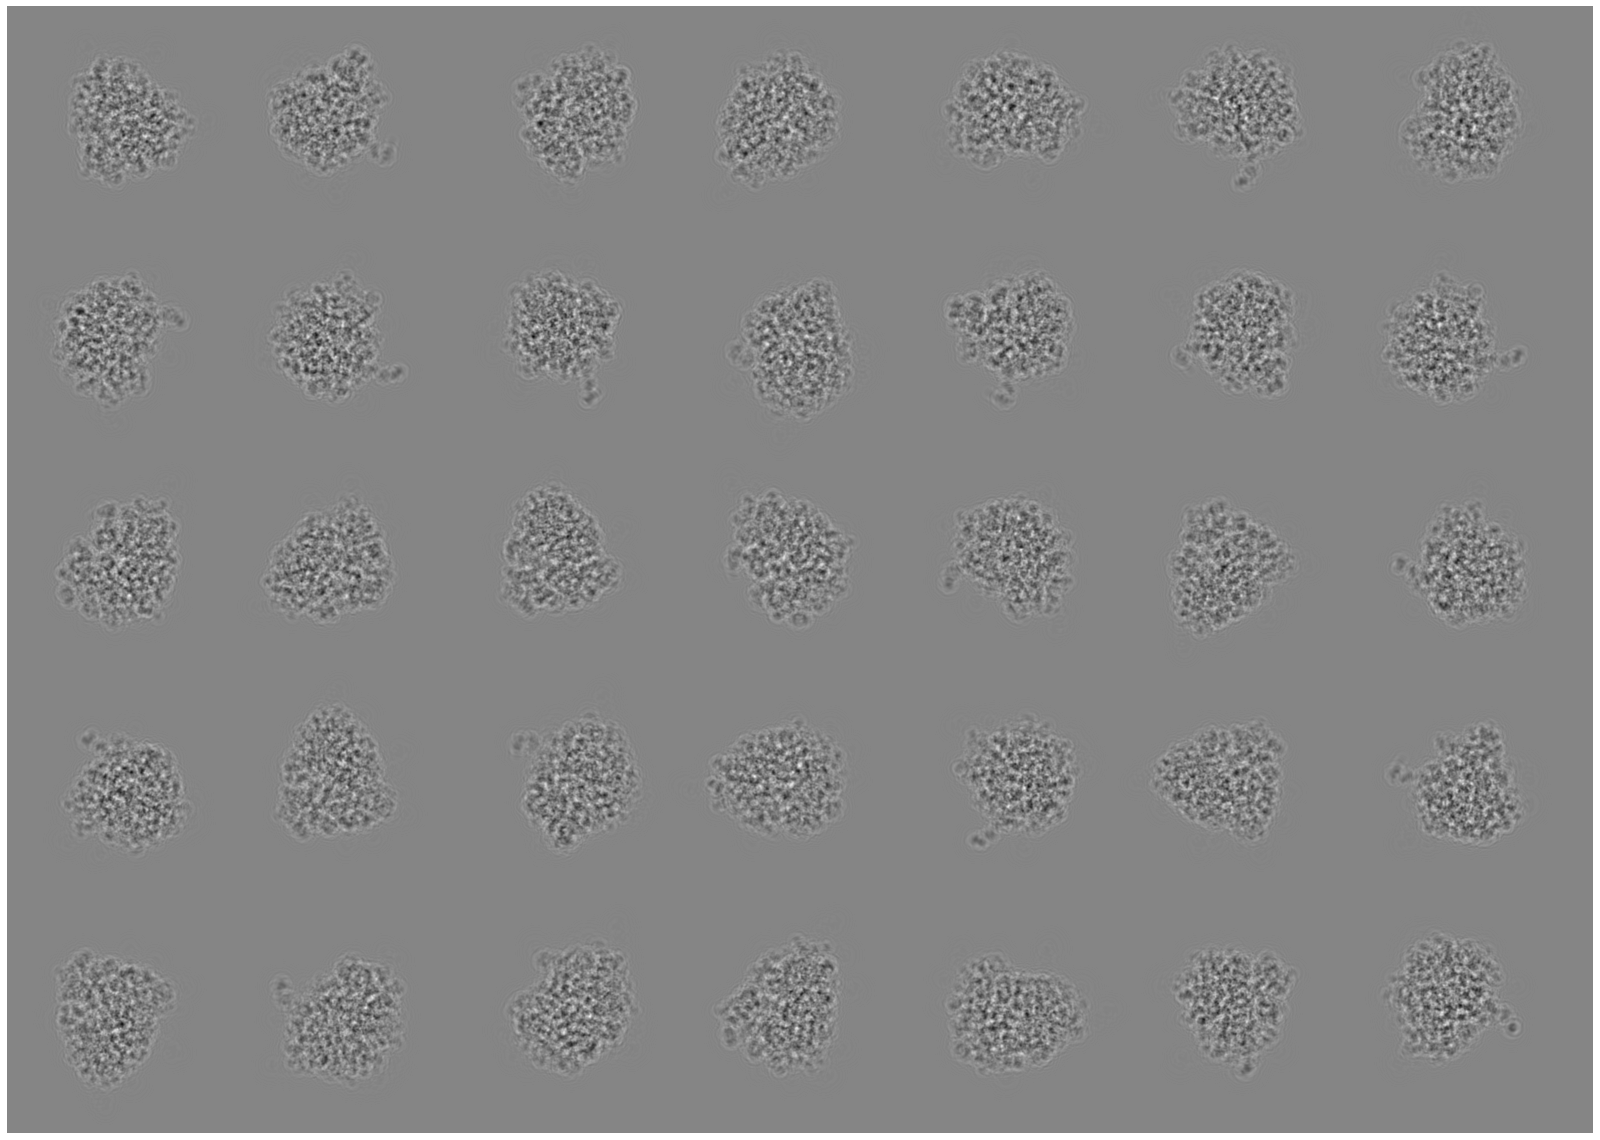

In [13]:
data = cryoemio.mrc2data(temSimulator.output_path_dict["mrc_file"])
micrograph = data[0, ...]

plot_image(micrograph, scale=0.5)

### Linear simulator
We provide several functionalities to work with micrographs. For instance, you can use the `linear_simulator.noise_utils` to apply gaussian noise to the micrograph. In order to to so we have to instanciate a `Noise` object, which uses PyTorch as backend. This object only receives as input a config `dict`. After instanciated we can use the `Noise.forward` function to apply the noise to the micrograph.

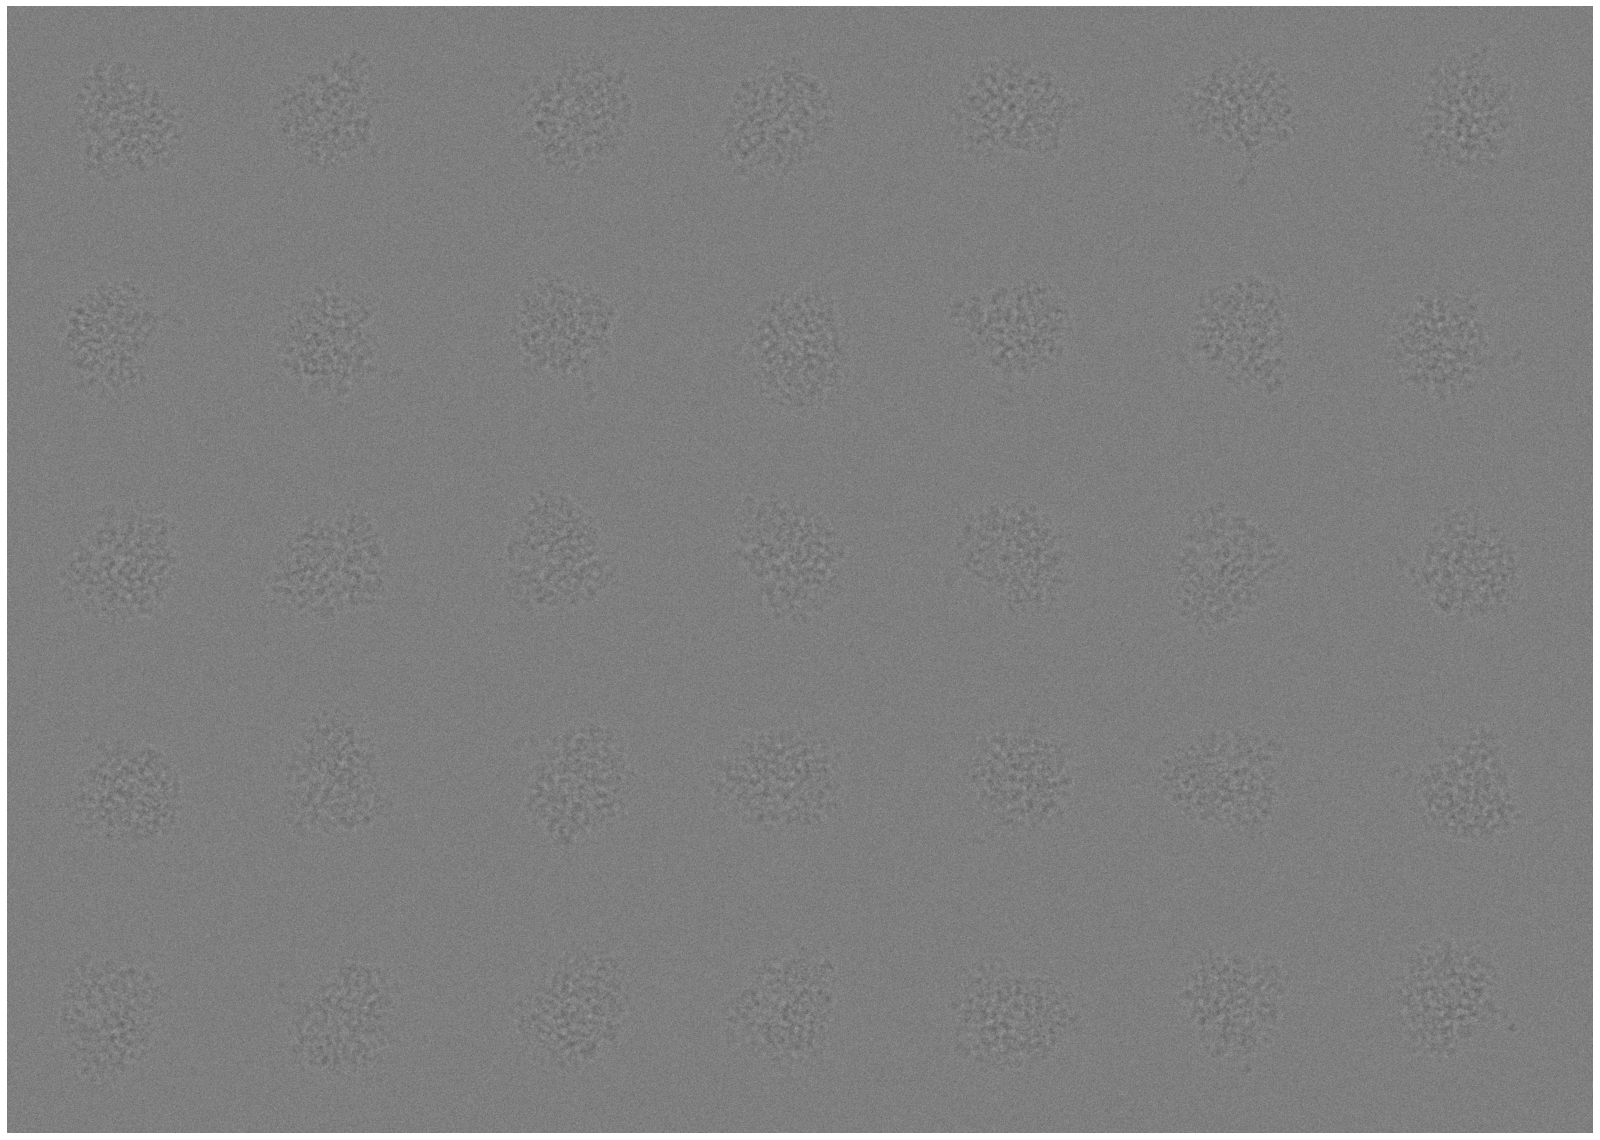

In [14]:
#Define the Noise that will be used
noise_config = {'noise': True, 'noise_sigma': 0.08, 'noise_distribution': 'gaussian'}
noise_config = AttrDict(noise_config)

#Create Noise object
gaussain_noise = noise_utils.Noise(noise_config)

#Apply the gaussian noise to the micrograph
micrograph_with_noise = gaussain_noise.forward(torch.tensor(micrograph))
micrograph_with_noise = micrograph_with_noise.numpy()

#Plot micrograph with gaussian noise added
plot_image(micrograph_with_noise, scale=0.5)

Since the `create_crd_file` function creates the coordinates for the particles in random rotations, but positioned in a grid like manner, it is very easy to recover the images of each of the particles used in the simulation with the `extract_particles` function.

In [15]:
#Selecting only the three first particles out of the 35
particles = temSimulator.extract_particles(micrograph, 5)[0:3]

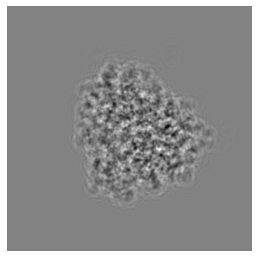

In [16]:
plot_image(particles[0], scale=0.4)

We additionaly have the `shift_utils` module from `linear_simulator`. Having extracted the particles from the micrograph we can use the `Shift` class to apply a spatial shift in the image particles.

In [17]:
#Defining shift config and params
n_particles = particles.shape[0]
box_size = particles.shape[1]
shift_amount = 50
shift_config = {'side_len': box_size, 'batch_size': n_particles, 'pixel_size': 1}
shift_config = AttrDict(shift_config)
shift_params = {'shift_x': torch.FloatTensor(n_particles).uniform_(-shift_amount,shift_amount),
                'shift_y': torch.FloatTensor(n_particles).uniform_(-shift_amount,shift_amount)}

#Instanciate a shift object
shift = shift_utils.Shift(shift_config)

In [18]:
#Shift of each particle
shift_params

{'shift_x': tensor([-30.2514, -31.3957, -40.6992]),
 'shift_y': tensor([-28.4806, -28.1610,  45.8447])}

Since the shift is done in fourier space, we have to calculate the fourier transform of the image particles.

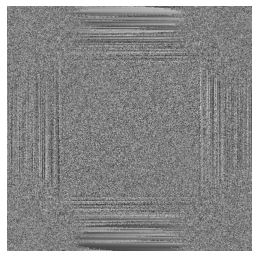

In [19]:
#Calculate the fourier transform of the particles
particles_ft = fourier.fft2d(arr2d=particles, mode='forward', batch=True)

#Calculate the phases and plot the phase spectrum for the first particle
particles_ft_phase = np.angle(particles_ft)
plot_image(particles_ft_phase[0], scale=0.4)

After computing the fourier transform of the particles we apply the phase shifts.

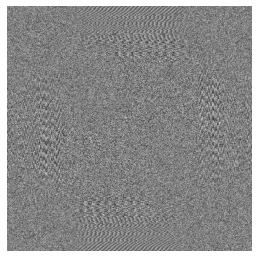

In [20]:
#Apply phase-shift in fourier domain
particles_ft = torch.tensor(particles_ft).reshape(n_particles, 1, box_size, box_size)
particles_ft_modulated = shift.forward(particles_ft, shift_params)

#Reshape the output and convert it back to a numpy array
particles_ft_modulated = particles_ft_modulated.reshape(n_particles, box_size, box_size).numpy()

#Calculate and plot the phase spectrum
particles_ft_mod_phase = np.angle(particles_ft_modulated)
plot_image(particles_ft_mod_phase[0], scale=0.4)

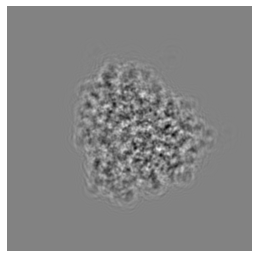

In [21]:
particles_ft = particles_ft.reshape(n_particles, box_size, box_size).numpy()

#Recover and plot the image in spatial domain
particles_ift = fourier.fft2d(particles_ft, 'inverse', batch=True)
plot_image(np.abs(particles_ift[0]), scale = 0.4)

(-0.5, 808.5, 808.5, -0.5)

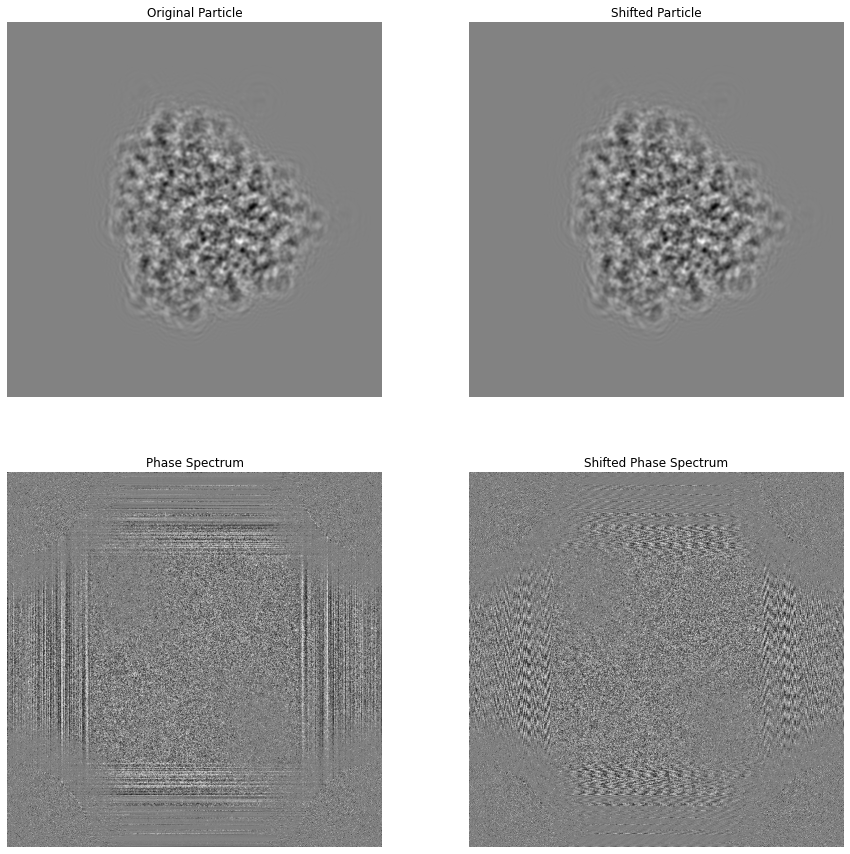

In [22]:
px = 1/plt.rcParams['figure.dpi']
scale = 1.35

f, ax = plt.subplots(2,2, figsize=(box_size*px*scale,box_size*px*scale))

ax[0,0].imshow(particles[0], cmap='gray')
ax[0,0].set_title('Original Particle')
ax[0,0].axis('off')

ax[0,1].imshow(np.abs(particles_ift[0]), cmap='gray')
ax[0,1].set_title('Shifted Particle')
ax[0,1].axis('off')

ax[1,0].imshow(np.abs(particles_ft_phase[0]), cmap='gray')
ax[1,0].set_title('Phase Spectrum')
ax[1,0].axis('off')

ax[1,1].imshow(np.abs(particles_ft_mod_phase[0]), cmap='gray')
ax[1,1].set_title('Shifted Phase Spectrum')
ax[1,1].axis('off')

# Transfer

The transfer module provides important resources for working with the Contrast Transfer Function (CTF). Includying the generation of user defined or random CTFs that can be used to create image particles closer to the ones who would be obtained in a real cryo-em experiment.

In [23]:
#Define parameters and create the CTF
n_pixels = particles[0].shape[0]
p_size = 1
freq_mag_2d, angles_rad = transfer.ctf_freqs(n_pixels, p_size)
ctf = transfer.eval_ctf(s=freq_mag_2d, a=angles_rad, def1=1e4, def2=1.1e4)

### Image formation

Now we can simulate the image formation in cryo-em process by multiplying in fourier space the particle fourier transform with the CTF. More formaly, we have $$\mathcal{F}(\text{Particle}) \times CTF = \mathcal{F}(\text{Particle} * PSF),$$ where $\text{PSF} = \mathcal{F}(\text{CTF})^{-1}$. As we did before, we will use the `fourier` module from `ioSPI` to calculate the fourier transform and the inverse fourier transform.

(-0.5, 808.5, 808.5, -0.5)

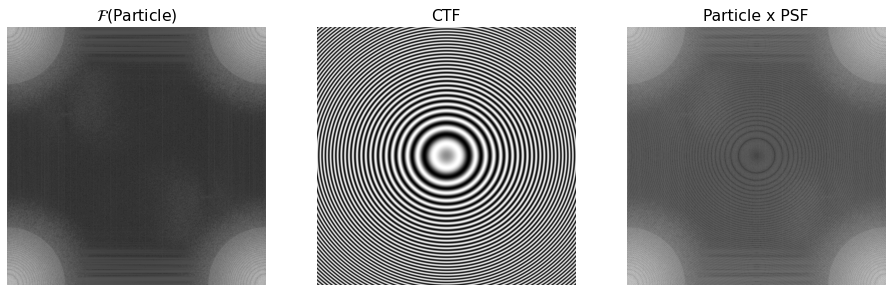

In [25]:
#Calculate the product of the CTF with the fourier transform of the particle
particle_ft_ctf = ctf * fourier.fft2d(arr2d = particles, mode = 'forward', batch=True)

plt.rcParams['font.size'] = 13
px = 1/plt.rcParams['figure.dpi']
scale = 1.4
f, ax = plt.subplots(1,3, figsize=(box_size*px*scale,box_size*px*scale))

ax[0].imshow(np.log(np.abs(particles_ft[0])), cmap='gray')
ax[0].set_title('$\mathcal{F} ($Particle$)$')
ax[0].axis('off')

ax[1].imshow(ctf, cmap='gray')
ax[1].set_title('CTF')
ax[1].axis('off')

ax[2].imshow(np.log(np.abs(particle_ft_ctf[0])), cmap='gray')
ax[2].set_title('Particle x PSF')
ax[2].axis('off')

Finally, we can simulate the effect of the CTF in the final image by calculating: $$\text{Particle} * \text{PSF} = \mathcal{F}^{-1}(\mathcal{F}(Particle) \times CTF)$$

(-0.5, 808.5, 808.5, -0.5)

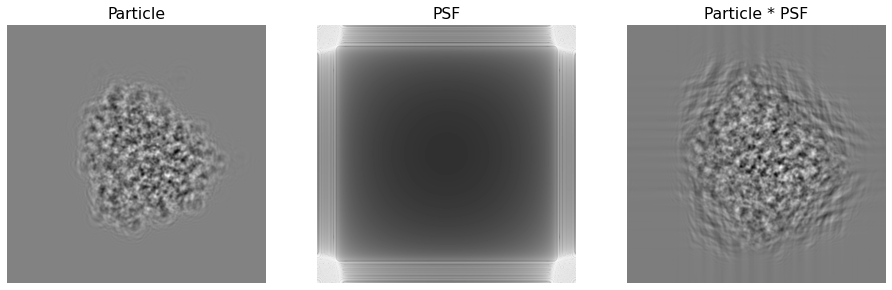

In [26]:
#Calculate the PSF, which is simply the inverse fourier transform of the CTF
psf = fourier.fft2d(arr2d = ctf, mode = 'inverse', batch=True)

#Calculate the particle convolved with PSF
particle_conv_psf = fourier.fft2d(arr2d = particle_ft_ctf, mode = 'inverse', batch=True)

plt.rcParams['font.size'] = 13
px = 1/plt.rcParams['figure.dpi']
scale = 1.4
f, ax = plt.subplots(1,3, figsize=(box_size*px*scale,box_size*px*scale))

ax[0].imshow(particles[0], cmap='gray')
ax[0].set_title('Particle')
ax[0].axis('off')

ax[1].imshow(np.log(np.abs(psf[0])), cmap='gray')
ax[1].set_title('PSF')
ax[1].axis('off')

ax[2].imshow(np.abs(particle_conv_psf[0]), cmap='gray')
ax[2].set_title('Particle * PSF')
ax[2].axis('off')

### Exit wave function

The library also contains functions to generate the exit wave function available in the `multislice` module. The `exit_wave_to_image()` function for instance, calculates the convolution of the CTF with the exit wave.

In [27]:
#Define a exit wave and plot it.
n_pixels = particles.shape[1]
sphere = raster_geometry.sphere(
    [n_pixels, n_pixels, n_pixels], radius=n_pixels // 8, position=0.25
).astype(np.float32)
ones = np.ones((n_pixels, n_pixels))
exit_wave = sphere.sum(-1)
plot_image(exit_wave, scale=0.4)

In [43]:
#Calculate the fourier transform of the exit wave
exit_wave_ft = fourier.do_fft(exit_wave, dim=2)

#Set a low dose to ploblems with the poisson distribution
high_dose = 1e2 * exit_wave.max()

image, shot_noise_sample, i0_dqe, i0 = multislice.exit_wave_to_image(
    exit_wave_f=exit_wave_ft,
    complex_ctf=ctf,
    dose=high_dose,
    noise_bg=0,
    dqe=ones,
    ntf=ones,
)

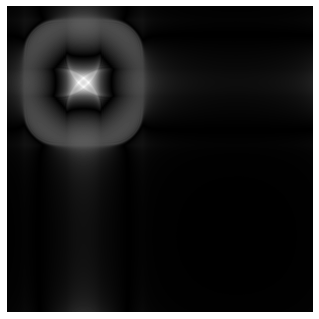

In [44]:
plot_image(image, 0.5)